In [1]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc
import muon as mu
import anndata
#import scvelo as scv

import numpy as np
import mplscience

In [2]:
adata = anndata.read_h5ad("./Pig_ovary_mesen.h5ad")
#scv.pl.proportions(adata)
adata

AnnData object with n_obs × n_vars = 11651 × 27339
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [3]:
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 11651 × 27339
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

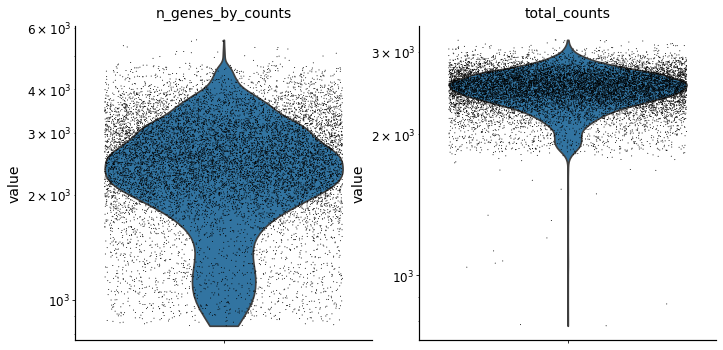

In [5]:
with mplscience.style_context():
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
                jitter=0.4, multi_panel=True, log=True)

In [6]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)

In [7]:

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata)

In [8]:
adata.layers["log_normalized"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 11415 × 17358
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'log1p'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'counts', 'log_normalized'
    obsp: 'connectivities', 'distances'

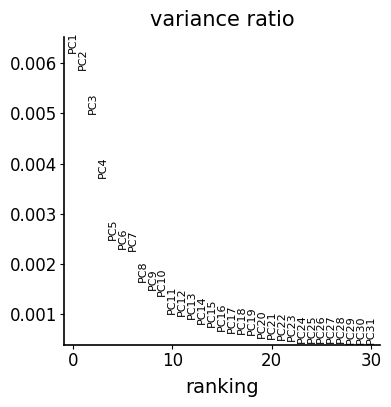

In [9]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata)

In [10]:
# rerun with fewer components
sc.tl.pca(adata, n_comps=10)

In [11]:
adata

AnnData object with n_obs × n_vars = 11415 × 17358
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'log1p'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity', 'counts', 'log_normalized'
    obsp: 'connectivities', 'distances'

In [12]:
adata.layers["counts"]

<11415x17358 sparse matrix of type '<class 'numpy.float32'>'
	with 29761991 stored elements in Compressed Sparse Row format>

In [13]:
import scipy
adata.layers["counts"]=scipy.sparse.csc_matrix(adata.layers["counts"])
adata.layers["counts"]

<11415x17358 sparse matrix of type '<class 'numpy.float32'>'
	with 29761991 stored elements in Compressed Sparse Column format>

In [14]:
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
adata.layers["counts_csc"] = adata.layers["counts"].tocsc()
hs = hotspot.Hotspot(
    adata,
    layer_key="counts_csc",
    model='danb',
    latent_obsm_key="X_pca",
    umi_counts_obs_key="total_counts"
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [15]:
hs_results = hs.compute_autocorrelations(jobs=30)

hs_results.head(15)

100%|██████████████████████████████████████████████████████████████████████████| 17358/17358 [00:12<00:00, 1394.93it/s]


,C,Z,Pval,FDR
Gene,,,,
ISG12(A),0.912467,441.318786,0.0,0.0
IFI6,0.907156,440.514134,0.0,0.0
ISG15,0.875460,418.525891,0.0,0.0
SLA-2,0.861705,416.634111,0.0,0.0
MX1,0.790542,372.223004,0.0,0.0
RGS5,0.726348,337.354284,0.0,0.0
RN18S,0.822065,321.159704,0.0,0.0
TOP2A,0.768442,318.477541,0.0,0.0
CENPF,0.772921,317.388341,0.0,0.0


In [16]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=30)

Computing pair-wise local correlation on 500 features...


100%|████████████████████████████████████████████████████████████████████████| 124750/124750 [00:13<00:00, 9575.72it/s]


In [17]:
modules = hs.create_modules(
    min_gene_threshold=15,   ## 数值增加会减少 module 数量
    core_only=True, fdr_threshold=0.05 
)

modules.value_counts()

 2     103
 3      93
 4      71
 5      37
-1      37
 6      34
 8      31
 9      29
 7      24
 1      22
 10     19
Name: Module, dtype: int64

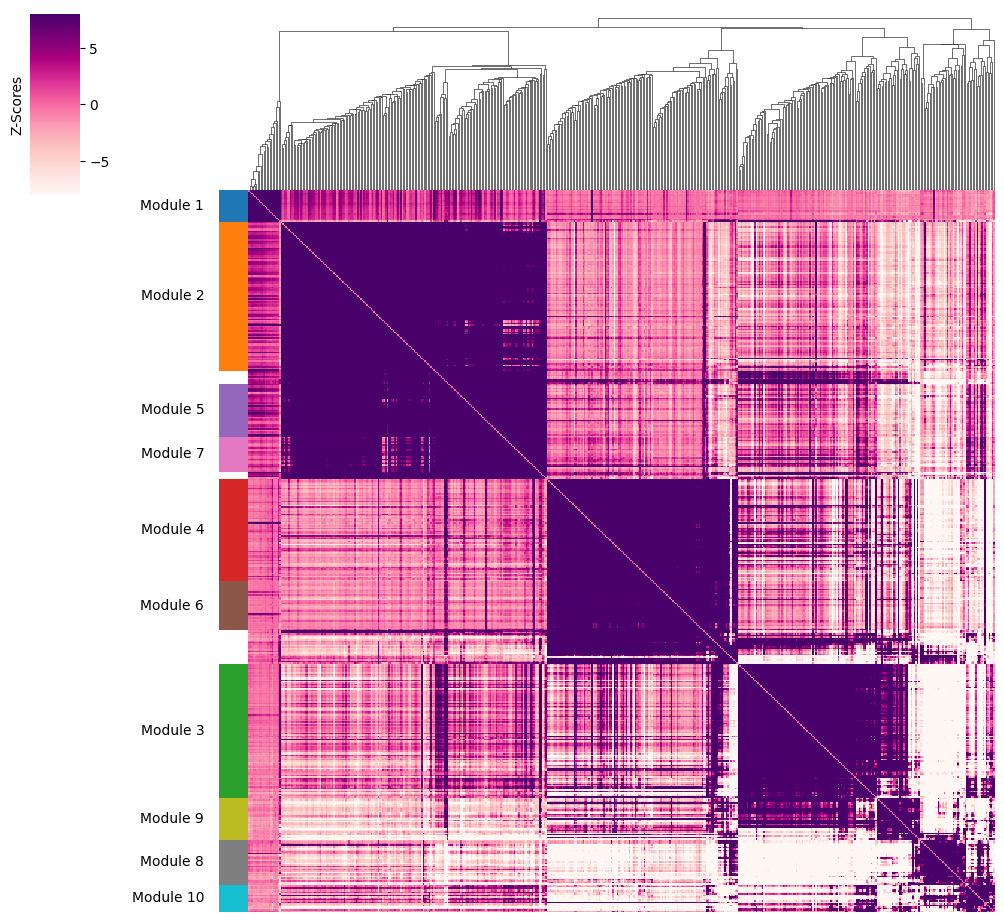

In [18]:
hs.plot_local_correlations(z_cmap='RdPu')
# viridis; magma

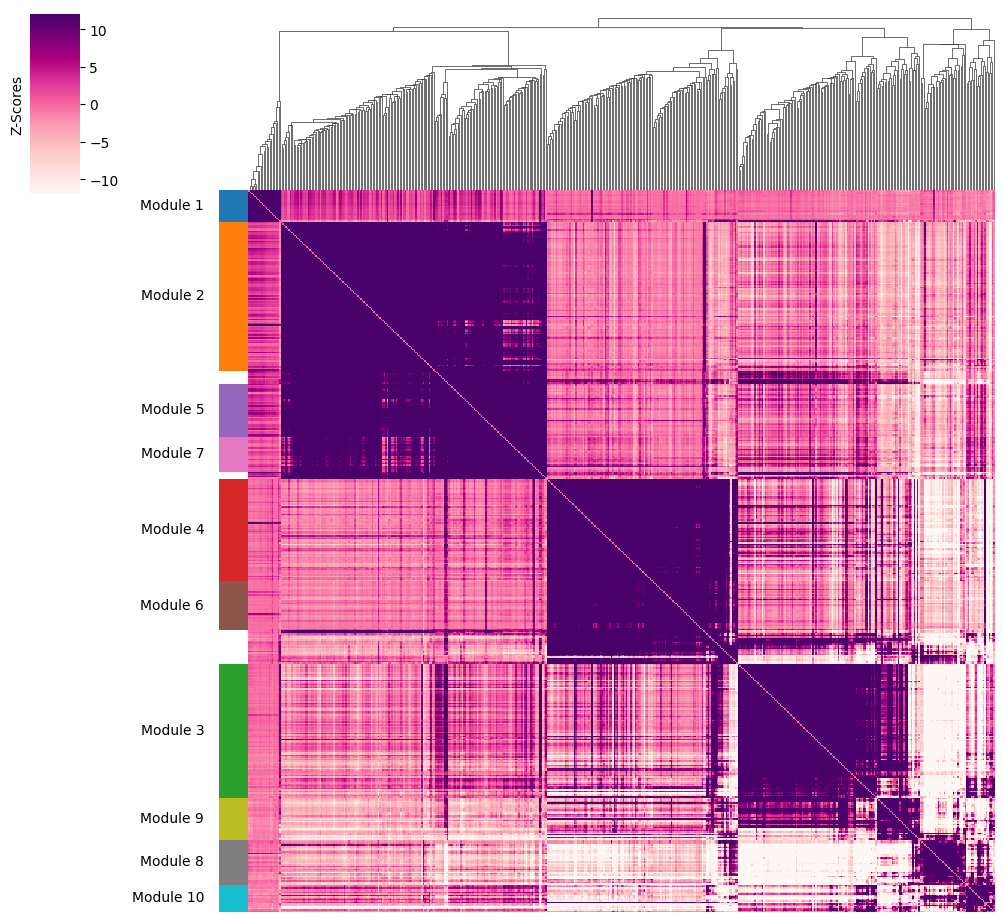

In [28]:
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt

with mpl.rc_context({'figure.figsize': (5, 5)}):
   fig = hs.plot_local_correlations(vmin=-12, vmax=12,z_cmap='RdPu')

#plt.savefig(fname="./figures/hotspot_dpi1200_mesen.pdf",dpi=1200, format="pdf")


In [19]:
import pandas as pd
# Show the top genes for a module

module = 9

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

#results.to_csv("./figures/mesen_module_gene/Mesen_module6.csv",index=True,sep=',')

,C,Z,Pval,FDR,Module
Gene,,,,,
PRSS23,0.379930,163.048628,0.0,0.0,9.0
HSP70.2,0.320876,134.755416,0.0,0.0,9.0
LOC106508546,0.338807,126.721355,0.0,0.0,9.0
SLC38A1,0.261513,112.325195,0.0,0.0,9.0
PI15,0.234079,111.147072,0.0,0.0,9.0
AR,0.260774,109.277121,0.0,0.0,9.0
LOC102163816,0.248184,102.164543,0.0,0.0,9.0
TGFBI,0.270985,102.031974,0.0,0.0,9.0
SERPINE2,0.413898,98.597876,0.0,0.0,9.0


In [20]:
results

,C,Z,Pval,FDR,Module
Gene,,,,,
PRSS23,0.379930,163.048628,0.0,0.0,9.0
HSP70.2,0.320876,134.755416,0.0,0.0,9.0
LOC106508546,0.338807,126.721355,0.0,0.0,9.0
SLC38A1,0.261513,112.325195,0.0,0.0,9.0
PI15,0.234079,111.147072,0.0,0.0,9.0
AR,0.260774,109.277121,0.0,0.0,9.0
LOC102163816,0.248184,102.164543,0.0,0.0,9.0
TGFBI,0.270985,102.031974,0.0,0.0,9.0
SERPINE2,0.413898,98.597876,0.0,0.0,9.0


In [21]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 10 modules...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.39it/s]


,1,2,3,4,5,6,7,8,9,10
E45:AAACCCAAGTAACCTCx,-0.242623,-1.103093,-2.919565,-0.771515,-0.956431,-0.529985,-1.048113,-0.831057,-1.700869,2.000597
E45:AAACCCACAATAACCCx,-0.243302,-1.708120,-2.973048,-1.296768,-1.333628,-0.604678,-0.995631,1.447545,-1.735337,1.440039
E45:AAACCCACATAACTCGx,-0.179151,-1.694963,-3.322849,-1.155145,-1.054126,-0.235100,-0.949837,2.762534,-0.674651,-0.844096
E45:AAACCCAGTGTTTCTTx,-0.186315,-1.783263,-2.454908,-1.081137,-1.266515,-0.615061,-0.848683,-0.408797,-1.340264,3.219263
E45:AAACCCAGTTACACACx,-0.269110,-1.691005,-3.121556,-1.285377,-1.322585,-0.388963,-0.973802,2.750581,-0.823104,-1.721888


In [22]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

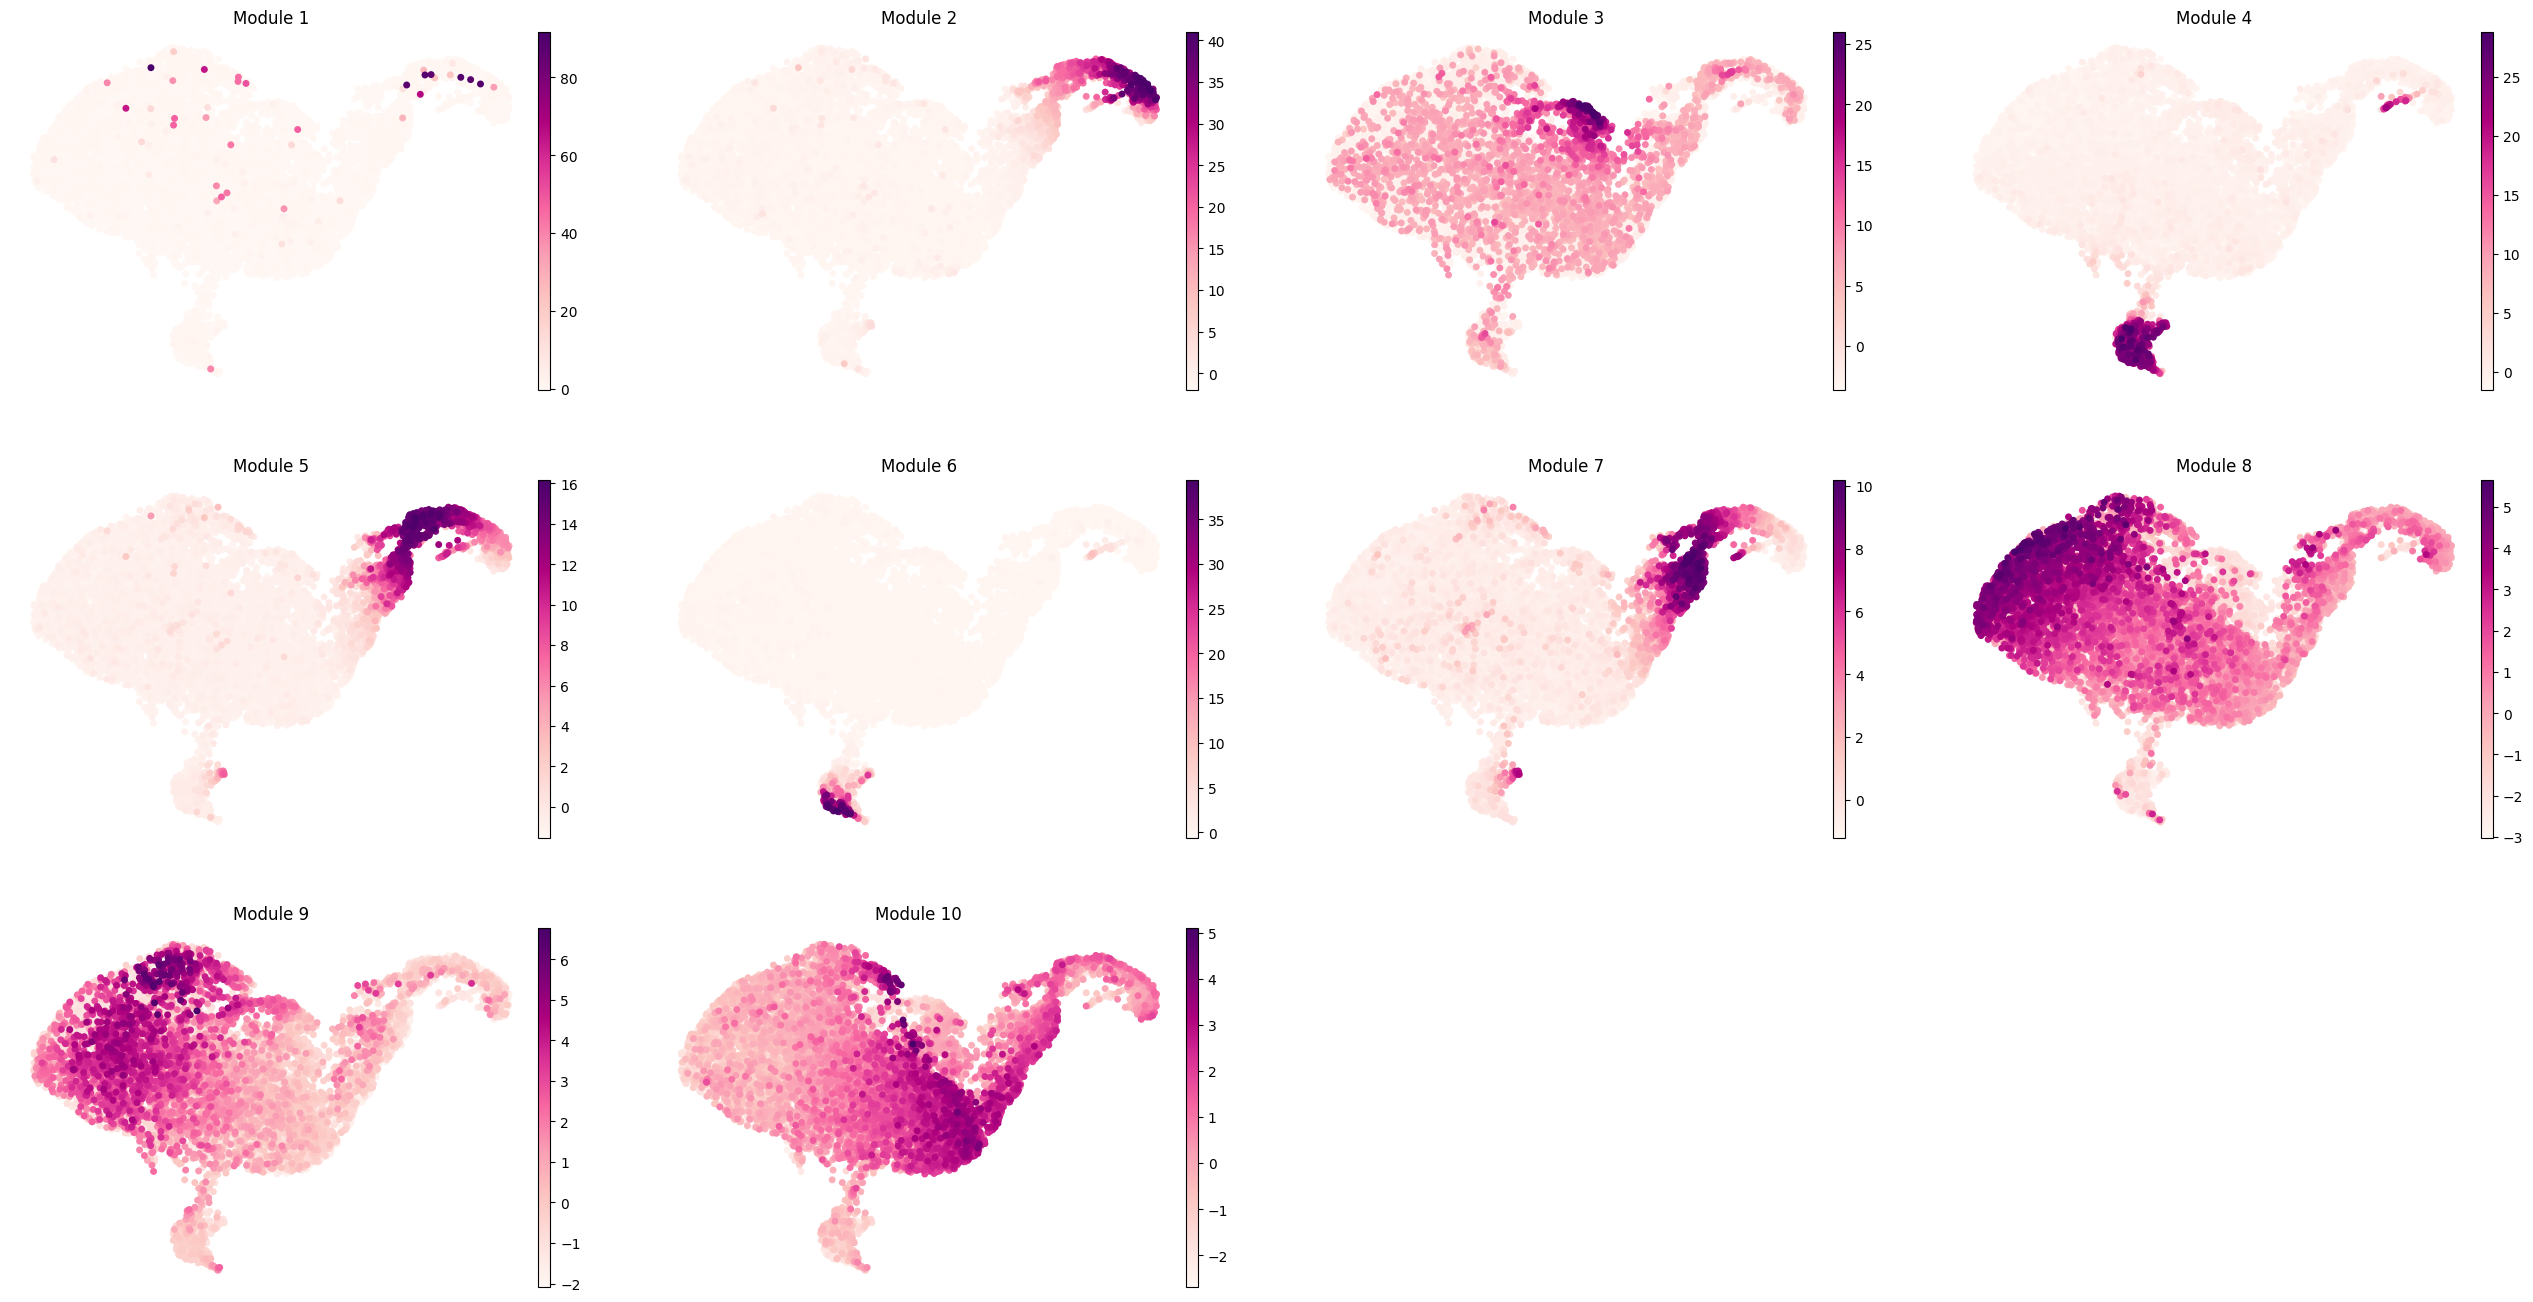

<Figure size 640x480 with 0 Axes>

In [29]:
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt


#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with rc_context({'figure.figsize': (7, 5)}):
    fig=sc.pl.umap(adata, color=module_cols, frameon=False,
               s=100, # 点大小
               # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="RdPu")
plt.savefig(fname="./figures/mesen_module_gene/Module_score_mesen.pdf",dpi=600, format="pdf")


In [27]:
module_cols

['Module 1',
 'Module 2',
 'Module 3',
 'Module 4',
 'Module 5',
 'Module 6',
 'Module 7',
 'Module 8',
 'Module 9',
 'Module 10']

In [42]:
my_module=["Module 4","Module 6"]

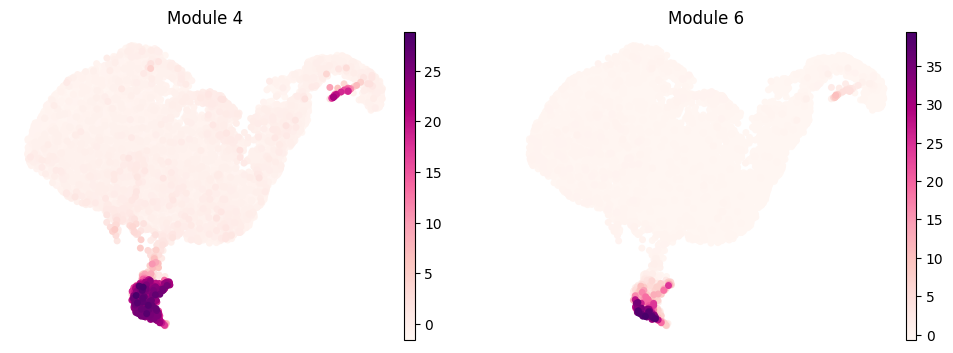

In [43]:
from matplotlib.pyplot import rc_context


#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with mpl.rc_context({'figure.figsize': (5, 4)}):
 fig = sc.pl.umap(adata, color=my_module, frameon=False,
               s=100, # 点大小
               # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="RdPu",
               save="Module_score_mesen_M46.pdf"
                 )
#plt.savefig(fname="./figures/mesen_module_gene/Module_score_mesen.pdf",dpi=600, format="pdf")

In [ ]:
from matplotlib.pyplot import rc_context

#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with mpl.rc_context({'figure.figsize': (8, 7)}):
 fig = sc.pl.umap(adata, color=module_cols, frameon=False,
               s=100, # 点大小
               # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="RdPu",
               save="Module_score_Granulosa.pdf")
#plt.savefig(fname="./figures/Module_score.pdf",dpi=600, format="pdf")


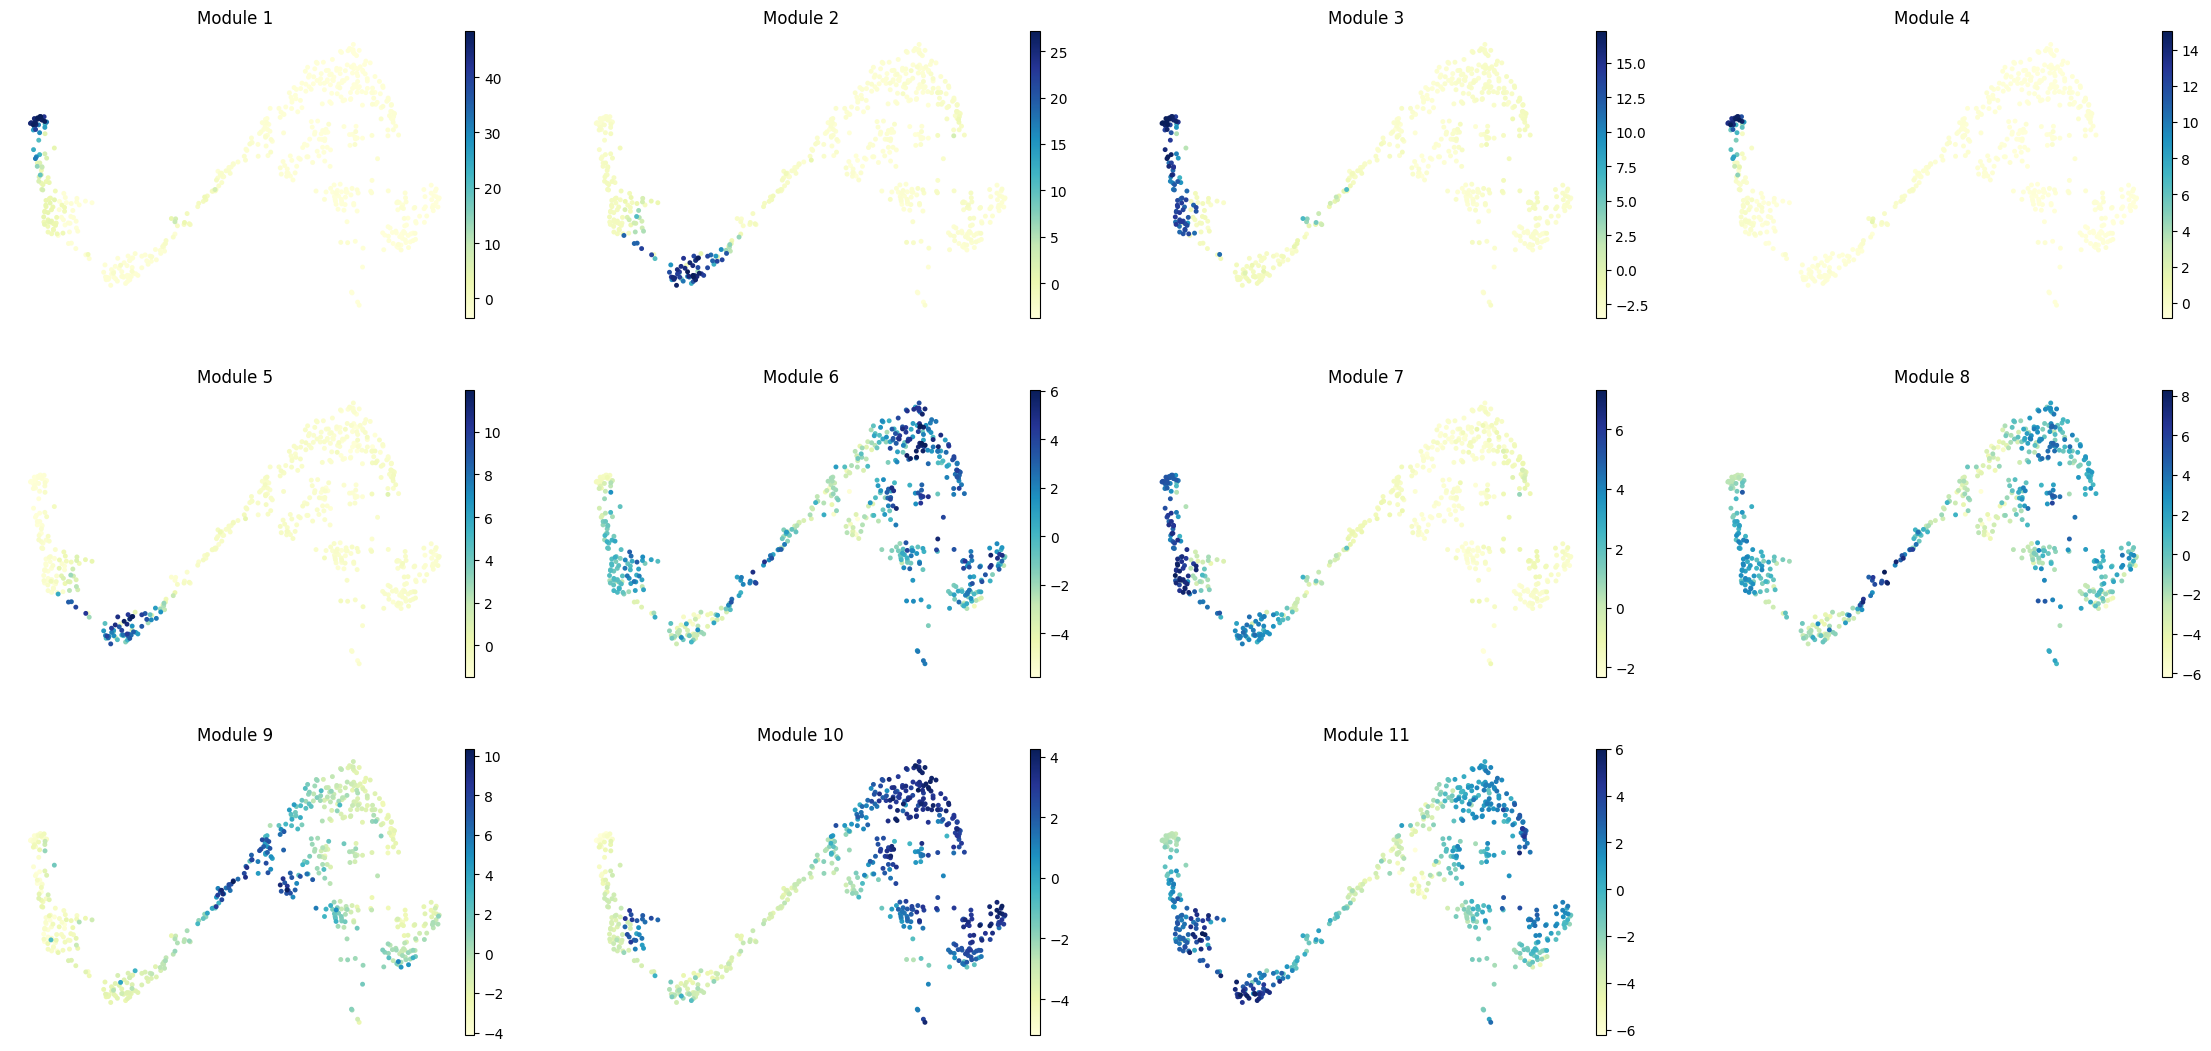

In [87]:
from matplotlib.pyplot import rc_context

#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with rc_context({'figure.figsize': (6, 4)}):
    sc.pl.umap(adata, color=module_cols, frameon=False, s=50, 
              # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="YlGnBu")